# Writing your own Pass

In the [Transpiler stages](transpiler-stages) topic we went over the default behavior of the transpiler and the various stages that compose a transpilation pipeline.  Qiskit allows you to create bespoke transpilation passes and run them in the `PassManager` object or add them to a `StagedPassMager`. Here we will introduce the DAG, which is the object manipulated by the `TransformationPass` type of pass. Our example performs [Pauli twirling](https://arxiv.org/abs/quant-ph/0606161) on the noisy quantum gates in a quantum circuit.


<details>
  <summary>
    DAG Representation
  </summary>

However, before we start it is important to first introduce the internal representation of quantum circuits in Qiskit, the [*Directed Acyclic Graph* or **DAG**](../api/qiskit/qiskit.dagcircuit.DAGCircuit.md) (see [this tutorial](https://qiskit.org/ecosystem/rustworkx/tutorial/dags.html) for an overview).  If you want to follow along here, you will need to install the `graphivz` library for the DAG plotting functions.  Use the python package manager of your choice (such as `pip` or `conda`) to install `pydot` and your system's native package manager (e.g. `apt`, `brew`, `yum`, `dnf`, etc.) for `graphivz`.

In Qiskit, specifically within the transpilation stages, circuits are represented using a Directed Acyclic Graph (DAG).  In general, a DAG is composed of *vertices* (also known as "nodes") and directed *edges* which connect pairs of vertices in a particular orientation.  This representation is stored using `qiskit.dagcircuit.DAGCircuit` objects which are composed of invididual `DagNode` objects.  The advantage of this representation over a pure list of gates (i.e. a *netlist*) is that the flow of information between operations is explicit, making it easier to make transformation decisions.  

Let's look at a simple example to understand the DAG a bit more by preparing a simple circuit which prepares a Bell state and applies an $R_Z$ rotation depending on the outcome of a measurement.
</details>

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

import numpy as np

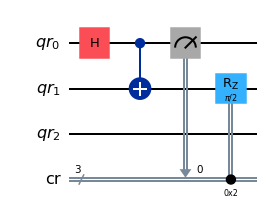

In [2]:
qr = QuantumRegister(3, 'qr')
cr = ClassicalRegister(3, 'cr')
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.measure(qr[0], cr[0])
qc.rz(np.pi/2, qr[1]).c_if(cr, 2)
qc.draw(output='mpl', style='iqp')

We can then view this circuit's DAG by using the `qiskit.tools.visualization.dag_drawer()` function.  You'll notice there are three kinds of graph nodes: qubit/clbit nodes (green `DAGInNode`s), operation nodes (blue `DAGOpNode`s), and output nodes (red `DAGOutNode`s).  Each edge indicates data flow (or dependency) between two nodes.

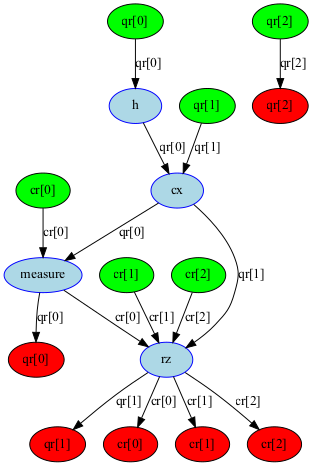

In [3]:
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer

dag = circuit_to_dag(qc)
dag_drawer(dag)

## Transpiler Passes

Transpiler passes are classified into one of two classes: Analysis passes and Transformation passes. Passes in general work with the Directed Acyclic Graph (DAG) **TODO: insert link here** and the `property_set`, a dictionary-like object for storing properties determined by analysis passes. Analysis passes work with the DAG, but are not allowed to modify it. This contrasts with transformation passes, which do modify the DAG, and can read (but not write to) `property_set`. 

## Create a `PauliTwirl` transpiler pass

As an example we construct a transpiler pass that adds Pauli twirls. [Pauli twirling](https://arxiv.org/abs/quant-ph/0606161) is an error suppression strategy that randomizes how the qubits experience noisy channels, which we assume to be two-qubit gates in this example (because they are much more error-prone than single-qubit gates). However, the Pauli twirls do not affect the actual operation of the two-qubit gate. They are chosen such that those applied *before* the two-qubit gate (to the left) are countered by those applied *after* the two-qubit gate (to the right). In this sense, the two-qubit operations are identical but the way they are performed is different. One benefit of Pauli twirling is that it turns coherent errors into stochastic errors, which can be improved by averaging more.

Transpiler passes act on the [DAG](../api/qiskit/qiskit.dagcircuit.DAGCircuit.md), so the important method to override is `.run()`, which takes the DAG as the input. Here we will also add the initialization of pairs of Paulis that preserve the operation of each two-qubit gate. This is done with the helper method `build_twirl_set` that goes through each two-qubit Pauli (as obtained from `pauli_basis(2)`) and finding the other Pauli that preserves the operation. 

From the DAG we can user the `op_nodes()` method to returns all of its nodes. We can also collect runs, which are sequence of nodes that run uninterrupted on a qubit. These can be collected as single-qubit runs with `collect_1q_runs`, two-qubit runs with `collect_2q_runs`, and runs of nodes where the instruction names are in a namelist with `collect_runs`.  The `DAGCircuit` has many methods for searching and traversing a graph, the most common method used is probably `topological_op_nodes`, which provides the nodes in a dependency ordering. Other methods such as `bfs_successors` are used primarily to determine how nodes interact with subsequent operations on a DAG. Here, we wish to replace each node, representing an instruction, with a subcircuit which we build as a mini DAG. The mini DAG has a two-qubit quantum register added to it, and operations are added here with `apply_operation_back`, which places the `Instruction` on the output of the mini DAG (whereas `apply_operation_front` would place it on the input of the mini DAG). The node is then substituted by the mini DAG with `substitute_node_with_dag`, and the process continues over each instance of `CXGate` and `ECRGate` in the DAG (corresponding to the two-qubit basis gates on IBM backends).

In [4]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit import Gate
from qiskit.circuit.library import CXGate, ECRGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator, pauli_basis

import numpy as np

from typing import Iterable, Optional

In [5]:
class PauliTwirl(TransformationPass):
    """Add Pauli twirls to two-qubit gates."""

    def __init__(
        self,
        gates_to_twirl: Optional[Iterable[Gate]] = None,
    ):
        """
        Args:
            gates_to_twirl: Names of gates to twirl. The default behavior is to twirl all
                two-qubit basis gates, `cx` and `ecr` for IBM backends.
        """
        if gates_to_twirl is None:
            gates_to_twirl = [CXGate(), ECRGate()]
        self.gates_to_twirl = gates_to_twirl
        self.build_twirl_set()
        super().__init__()

    def build_twirl_set(self):
        """
        Build set of Paulis to twirl for each gate and store internally as .twirl_set.
        """
        self.twirl_set = {}

        # iterate through gates to be twirled
        for twirl_gate in self.gates_to_twirl:
            twirl_list = []

            # iterate through Paulis on left of gate to twirl
            for pauli_left in pauli_basis(2):

                # iterature through Paulis on right of gate to twirl
                for pauli_right in pauli_basis(2):

                    # save pairs that produce identical operation as gate to twirl
                    if (Operator(pauli_left) @ Operator(twirl_gate)).equiv(Operator(twirl_gate) @ pauli_right):
                        twirl_list.append((pauli_left, pauli_right))

            self.twirl_set[twirl_gate.name] = twirl_list

    def run(
        self,
        dag: DAGCircuit,
    ) -> DAGCircuit:
        
        # collect all nodes in DAG and proceed if it is to be twirled
        twirling_gate_classes = tuple(gate.base_class for gate in self.gates_to_twirl)
        for node in dag.op_nodes():
            if not isinstance(node.op, twirling_gate_classes):
                continue

            # random integer to select Pauli twirl pair
            pidx = np.random.randint(0, len(self.twirl_set[node.op.name]),)
            twirl_pair = self.twirl_set[node.op.name][pidx]

            # instantiate mini_dag and attach quantum register
            mini_dag = DAGCircuit()
            register = QuantumRegister(2)
            mini_dag.add_qreg(register)

            # apply left Pauli, gate to twirl, and right Pauli to empty mini-DAG
            mini_dag.apply_operation_back(twirl_pair[0].to_instruction(), [register[0], register[1]])
            mini_dag.apply_operation_back(node.op, [register[0], register[1]])
            mini_dag.apply_operation_back(twirl_pair[1].to_instruction(), [register[0], register[1]])

            # substitute gate to twirl node with twirling mini-DAG
            dag.substitute_node_with_dag(node, mini_dag)

        return dag

Consider a simple circuit with `cx`s and `ecr`s.

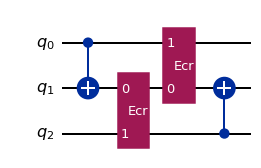

In [6]:
qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.ecr(1, 2)
qc.ecr(1, 0)
qc.cx(2, 1)
qc.draw('mpl', style='iqp')

Since we are applying a single pass, we can use the shorthand for `PassManager(PauliTwirl()).run(qc)` to generate 50 randomized circuits. 

In [7]:
pm = PassManager([PauliTwirl()])
twirled_qcs = [pm.run(qc) for _ in range(50)]

We can see that each two-qubit gate is now sandwiched between two Paulis.

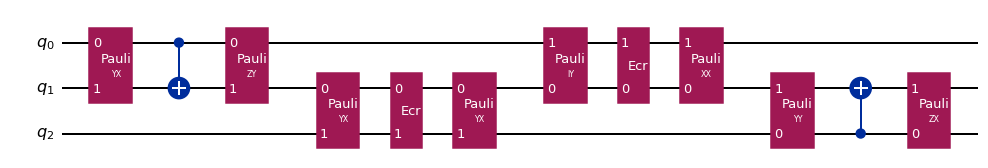

In [8]:
twirled_qcs[-1].draw('mpl', style='iqp')

And confirming that the operators are actually the same using `Operator` from `qiskit.quantum_info`.

In [9]:
np.alltrue([Operator(twirled_qc).equiv(qc) for twirled_qc in twirled_qcs])

True